In [21]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, pin_memory=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False, pin_memory=True)


In [22]:
# Architecture
import torch
import torch.nn as nn
import torch.nn.functional as F

class IntermediateBlock(nn.Module):
    def __init__(self, input_channels, output_channels, num_convs, dropout_rate=0.2):
        super().__init__()
        self.num_convs = num_convs

        # L convolutional layers
        self.convs = nn.ModuleList([
           nn.Sequential(
               nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
               nn.BatchNorm2d(output_channels),
               nn.ReLU(),
               nn.Dropout(dropout_rate)
            )
            for _ in range(num_convs)
        ])

        # FC layer that maps from input_channels to num_convs
        self.fc = nn.Linear(input_channels, num_convs)

    def forward(self, x):
        B, C, H, W = x.shape
        
        # Compute channel-wise mean vector (m)
        m = x.mean(dim=(2, 3))  # shape [B, C]

        # Compute coefficients (a) using the FC layer
        a = self.fc(m)  # shape [B, L]
        a = F.softmax(a, dim=1)  # normalize weights
        
        # Apply each conv layer to the same input
        conv_outputs = torch.stack([conv(x) for conv in self.convs], dim=1)

        # Reshape a to broadcast over conv_outputs
        a = a.view(B, self.num_convs, 1, 1, 1)

        # Weighted sum over L convolution outputs
        x_prime = (a * conv_outputs).sum(dim=1)
        return x_prime

class OutputBlock(nn.Module):
    def __init__(self, input_channels, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_channels, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 10)

    def forward(self, x):
        B, C, H, W = x.shape
        m = x.mean(dim=(2, 3))  # shape [B, C]
        x = F.relu(self.fc1(m))
        logits = self.fc2(x)
        return logits

class CIFARNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = IntermediateBlock(3, 32, num_convs=3, dropout_rate=0.2)
        self.block2 = IntermediateBlock(32, 64, num_convs=3, dropout_rate=0.3)
        self.block3 = IntermediateBlock(64, 96, num_convs=3, dropout_rate=0.3)
        self.block4 = IntermediateBlock(96, 128, num_convs=3, dropout_rate=0.3)
        self.block5 = IntermediateBlock(128, 192, num_convs=2, dropout_rate=0.3)
        self.block6 = IntermediateBlock(192, 256, num_convs=2, dropout_rate=0.3)
        self.output = OutputBlock(256)

    def forward(self, x):
        x = self.block1(x)
        x = F.relu(x)
        x = self.block2(x)
        x = F.relu(x)
        x = self.block3(x)
        x = F.relu(x)
        x = self.block4(x)
        x = F.relu(x)
        x = self.block5(x)
        x = F.relu(x)
        x = self.block6(x)
        x = F.relu(x)
        logits = self.output(x)
        return logits


In [23]:
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from torch.optim.lr_scheduler import CosineAnnealingLR

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFARNet().to(device)

# Training settings
epochs = 150
train_losses = []
train_accuracies = []
test_accuracies = []
best_test_acc = 0.0

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

for epoch in range(epochs):
    start_time = time.perf_counter()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item()
        train_losses.append(loss.item())
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        loop.set_postfix(loss=loss.item(), accuracy=100.*correct/total)

    train_acc = 100. * correct / total
    train_accuracies.append(train_acc)

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100. * correct / total
    test_accuracies.append(test_acc)
    if test_acc > best_test_acc:
        best_test_acc = test_acc

    end_time = time.perf_counter()
    scheduler.step()

    print(f"Epoch {epoch+1}: Train Accuracy = {train_acc:.2f}%, Test Accuracy = {test_acc:.2f}%, Duration: {end_time - start_time:.3f}s.")

# Best test accuracy
print(f"\nHighest Test Accuracy Achieved: {best_test_acc:.2f}%")


Epoch 1/150: 100%|██████████| 782/782 [02:51<00:00,  4.55it/s, accuracy=31.1, loss=1.41]


Epoch 1: Train Accuracy = 31.11%, Test Accuracy = 33.63%, Duration: 183.559s.


Epoch 2/150: 100%|██████████| 782/782 [03:09<00:00,  4.13it/s, accuracy=48, loss=1.7]   


Epoch 2: Train Accuracy = 48.03%, Test Accuracy = 52.06%, Duration: 201.963s.


Epoch 3/150: 100%|██████████| 782/782 [03:22<00:00,  3.86it/s, accuracy=57.3, loss=1.15]


Epoch 3: Train Accuracy = 57.32%, Test Accuracy = 49.88%, Duration: 214.753s.


Epoch 4/150: 100%|██████████| 782/782 [03:19<00:00,  3.92it/s, accuracy=62.1, loss=1.22]


Epoch 4: Train Accuracy = 62.11%, Test Accuracy = 54.15%, Duration: 212.505s.


Epoch 5/150: 100%|██████████| 782/782 [03:53<00:00,  3.35it/s, accuracy=65.7, loss=1.26] 


Epoch 5: Train Accuracy = 65.68%, Test Accuracy = 63.71%, Duration: 248.019s.


Epoch 6/150: 100%|██████████| 782/782 [03:55<00:00,  3.32it/s, accuracy=69, loss=1.35]   


Epoch 6: Train Accuracy = 68.96%, Test Accuracy = 70.49%, Duration: 250.731s.


Epoch 7/150: 100%|██████████| 782/782 [03:53<00:00,  3.35it/s, accuracy=71.1, loss=0.883]


Epoch 7: Train Accuracy = 71.08%, Test Accuracy = 67.41%, Duration: 247.720s.


Epoch 8/150: 100%|██████████| 782/782 [03:54<00:00,  3.34it/s, accuracy=72.9, loss=0.975]


Epoch 8: Train Accuracy = 72.94%, Test Accuracy = 65.90%, Duration: 248.324s.


Epoch 9/150: 100%|██████████| 782/782 [03:52<00:00,  3.36it/s, accuracy=74.6, loss=1.17] 


Epoch 9: Train Accuracy = 74.61%, Test Accuracy = 71.74%, Duration: 247.060s.


Epoch 10/150: 100%|██████████| 782/782 [03:51<00:00,  3.38it/s, accuracy=76.3, loss=1.06] 


Epoch 10: Train Accuracy = 76.30%, Test Accuracy = 73.50%, Duration: 245.614s.


Epoch 11/150: 100%|██████████| 782/782 [03:49<00:00,  3.41it/s, accuracy=77.2, loss=0.859]


Epoch 11: Train Accuracy = 77.20%, Test Accuracy = 74.41%, Duration: 243.707s.


Epoch 12/150: 100%|██████████| 782/782 [03:50<00:00,  3.39it/s, accuracy=78.4, loss=1.4]  


Epoch 12: Train Accuracy = 78.42%, Test Accuracy = 74.16%, Duration: 245.415s.


Epoch 13/150: 100%|██████████| 782/782 [03:50<00:00,  3.39it/s, accuracy=79.2, loss=0.921]


Epoch 13: Train Accuracy = 79.25%, Test Accuracy = 77.79%, Duration: 244.279s.


Epoch 14/150: 100%|██████████| 782/782 [03:49<00:00,  3.41it/s, accuracy=79.9, loss=1.18] 


Epoch 14: Train Accuracy = 79.90%, Test Accuracy = 73.83%, Duration: 243.890s.


Epoch 15/150: 100%|██████████| 782/782 [03:49<00:00,  3.41it/s, accuracy=80.7, loss=0.896]


Epoch 15: Train Accuracy = 80.66%, Test Accuracy = 79.16%, Duration: 244.150s.


Epoch 16/150: 100%|██████████| 782/782 [03:50<00:00,  3.40it/s, accuracy=81.3, loss=1.03] 


Epoch 16: Train Accuracy = 81.34%, Test Accuracy = 79.16%, Duration: 244.687s.


Epoch 17/150: 100%|██████████| 782/782 [03:48<00:00,  3.42it/s, accuracy=81.9, loss=0.682]


Epoch 17: Train Accuracy = 81.90%, Test Accuracy = 79.64%, Duration: 243.035s.


Epoch 18/150: 100%|██████████| 782/782 [03:47<00:00,  3.43it/s, accuracy=81.9, loss=1.08] 


Epoch 18: Train Accuracy = 81.93%, Test Accuracy = 81.33%, Duration: 241.518s.


Epoch 19/150: 100%|██████████| 782/782 [03:51<00:00,  3.38it/s, accuracy=82.3, loss=1.09] 


Epoch 19: Train Accuracy = 82.31%, Test Accuracy = 77.56%, Duration: 245.457s.


Epoch 20/150: 100%|██████████| 782/782 [03:46<00:00,  3.45it/s, accuracy=82.9, loss=0.967]


Epoch 20: Train Accuracy = 82.90%, Test Accuracy = 82.53%, Duration: 240.225s.


Epoch 21/150: 100%|██████████| 782/782 [03:46<00:00,  3.45it/s, accuracy=83.3, loss=1.2]  


Epoch 21: Train Accuracy = 83.31%, Test Accuracy = 79.16%, Duration: 239.636s.


Epoch 22/150: 100%|██████████| 782/782 [03:47<00:00,  3.44it/s, accuracy=83.6, loss=0.871]


Epoch 22: Train Accuracy = 83.62%, Test Accuracy = 82.12%, Duration: 241.346s.


Epoch 23/150: 100%|██████████| 782/782 [03:44<00:00,  3.48it/s, accuracy=83.7, loss=0.787]


Epoch 23: Train Accuracy = 83.75%, Test Accuracy = 77.76%, Duration: 237.506s.


Epoch 24/150: 100%|██████████| 782/782 [03:44<00:00,  3.48it/s, accuracy=84, loss=0.886]  


Epoch 24: Train Accuracy = 83.99%, Test Accuracy = 82.22%, Duration: 238.610s.


Epoch 25/150: 100%|██████████| 782/782 [03:44<00:00,  3.48it/s, accuracy=84.2, loss=0.666]


Epoch 25: Train Accuracy = 84.16%, Test Accuracy = 80.97%, Duration: 237.889s.


Epoch 26/150: 100%|██████████| 782/782 [03:46<00:00,  3.44it/s, accuracy=84.6, loss=0.892]


Epoch 26: Train Accuracy = 84.58%, Test Accuracy = 83.22%, Duration: 241.087s.


Epoch 27/150: 100%|██████████| 782/782 [03:41<00:00,  3.54it/s, accuracy=85, loss=1.08]   


Epoch 27: Train Accuracy = 85.01%, Test Accuracy = 83.76%, Duration: 234.846s.


Epoch 28/150: 100%|██████████| 782/782 [03:43<00:00,  3.50it/s, accuracy=84.7, loss=1.06] 


Epoch 28: Train Accuracy = 84.72%, Test Accuracy = 80.02%, Duration: 237.514s.


Epoch 29/150: 100%|██████████| 782/782 [03:47<00:00,  3.44it/s, accuracy=85, loss=0.624]  


Epoch 29: Train Accuracy = 85.04%, Test Accuracy = 83.44%, Duration: 240.960s.


Epoch 30/150: 100%|██████████| 782/782 [03:45<00:00,  3.46it/s, accuracy=85.4, loss=0.787]


Epoch 30: Train Accuracy = 85.36%, Test Accuracy = 79.15%, Duration: 238.361s.


Epoch 31/150: 100%|██████████| 782/782 [03:38<00:00,  3.57it/s, accuracy=85.7, loss=1.08] 


Epoch 31: Train Accuracy = 85.69%, Test Accuracy = 83.63%, Duration: 232.094s.


Epoch 32/150: 100%|██████████| 782/782 [03:43<00:00,  3.50it/s, accuracy=86, loss=1.06]   


Epoch 32: Train Accuracy = 85.99%, Test Accuracy = 80.87%, Duration: 237.241s.


Epoch 33/150: 100%|██████████| 782/782 [03:45<00:00,  3.47it/s, accuracy=86.2, loss=1.15] 


Epoch 33: Train Accuracy = 86.21%, Test Accuracy = 84.49%, Duration: 238.583s.


Epoch 34/150: 100%|██████████| 782/782 [03:42<00:00,  3.52it/s, accuracy=86.3, loss=0.836]


Epoch 34: Train Accuracy = 86.27%, Test Accuracy = 84.58%, Duration: 236.090s.


Epoch 35/150: 100%|██████████| 782/782 [03:42<00:00,  3.52it/s, accuracy=86.2, loss=0.796]


Epoch 35: Train Accuracy = 86.20%, Test Accuracy = 84.02%, Duration: 236.000s.


Epoch 36/150: 100%|██████████| 782/782 [03:43<00:00,  3.50it/s, accuracy=86.4, loss=0.847]


Epoch 36: Train Accuracy = 86.38%, Test Accuracy = 82.01%, Duration: 236.731s.


Epoch 37/150: 100%|██████████| 782/782 [03:39<00:00,  3.57it/s, accuracy=87, loss=0.838]  


Epoch 37: Train Accuracy = 86.97%, Test Accuracy = 84.58%, Duration: 232.561s.


Epoch 38/150: 100%|██████████| 782/782 [03:37<00:00,  3.59it/s, accuracy=86.9, loss=0.841]


Epoch 38: Train Accuracy = 86.92%, Test Accuracy = 84.16%, Duration: 231.120s.


Epoch 39/150: 100%|██████████| 782/782 [03:41<00:00,  3.53it/s, accuracy=86.9, loss=0.757]


Epoch 39: Train Accuracy = 86.86%, Test Accuracy = 82.13%, Duration: 235.014s.


Epoch 40/150: 100%|██████████| 782/782 [03:40<00:00,  3.55it/s, accuracy=87.2, loss=0.795]


Epoch 40: Train Accuracy = 87.16%, Test Accuracy = 84.86%, Duration: 234.076s.


Epoch 41/150: 100%|██████████| 782/782 [03:39<00:00,  3.56it/s, accuracy=87.3, loss=0.981]


Epoch 41: Train Accuracy = 87.33%, Test Accuracy = 81.81%, Duration: 233.235s.


Epoch 42/150: 100%|██████████| 782/782 [03:37<00:00,  3.60it/s, accuracy=87.5, loss=1.13] 


Epoch 42: Train Accuracy = 87.49%, Test Accuracy = 79.31%, Duration: 230.976s.


Epoch 43/150: 100%|██████████| 782/782 [03:39<00:00,  3.56it/s, accuracy=87.5, loss=0.711]


Epoch 43: Train Accuracy = 87.46%, Test Accuracy = 83.07%, Duration: 233.238s.


Epoch 44/150: 100%|██████████| 782/782 [03:39<00:00,  3.57it/s, accuracy=87.7, loss=0.871]


Epoch 44: Train Accuracy = 87.72%, Test Accuracy = 84.23%, Duration: 232.419s.


Epoch 45/150: 100%|██████████| 782/782 [03:38<00:00,  3.58it/s, accuracy=87.6, loss=0.697]


Epoch 45: Train Accuracy = 87.55%, Test Accuracy = 85.11%, Duration: 232.193s.


Epoch 46/150: 100%|██████████| 782/782 [03:37<00:00,  3.59it/s, accuracy=88.1, loss=0.662]


Epoch 46: Train Accuracy = 88.07%, Test Accuracy = 83.64%, Duration: 230.850s.


Epoch 47/150: 100%|██████████| 782/782 [03:36<00:00,  3.62it/s, accuracy=87.9, loss=1.12] 


Epoch 47: Train Accuracy = 87.95%, Test Accuracy = 84.79%, Duration: 229.438s.


Epoch 48/150: 100%|██████████| 782/782 [03:38<00:00,  3.58it/s, accuracy=88, loss=0.721]  


Epoch 48: Train Accuracy = 88.01%, Test Accuracy = 83.14%, Duration: 231.728s.


Epoch 49/150: 100%|██████████| 782/782 [03:38<00:00,  3.58it/s, accuracy=88.1, loss=0.802]


Epoch 49: Train Accuracy = 88.14%, Test Accuracy = 87.14%, Duration: 232.001s.


Epoch 50/150: 100%|██████████| 782/782 [03:37<00:00,  3.59it/s, accuracy=88.3, loss=1.05] 


Epoch 50: Train Accuracy = 88.31%, Test Accuracy = 84.97%, Duration: 230.908s.


Epoch 51/150: 100%|██████████| 782/782 [03:35<00:00,  3.63it/s, accuracy=88.6, loss=0.768]


Epoch 51: Train Accuracy = 88.62%, Test Accuracy = 85.45%, Duration: 228.912s.


Epoch 52/150: 100%|██████████| 782/782 [03:36<00:00,  3.61it/s, accuracy=88.4, loss=1.08] 


Epoch 52: Train Accuracy = 88.37%, Test Accuracy = 85.64%, Duration: 230.176s.


Epoch 53/150: 100%|██████████| 782/782 [03:35<00:00,  3.63it/s, accuracy=89, loss=0.933]  


Epoch 53: Train Accuracy = 89.00%, Test Accuracy = 83.53%, Duration: 229.486s.


Epoch 54/150: 100%|██████████| 782/782 [03:38<00:00,  3.58it/s, accuracy=89, loss=0.716]  


Epoch 54: Train Accuracy = 88.98%, Test Accuracy = 84.54%, Duration: 231.865s.


Epoch 55/150: 100%|██████████| 782/782 [03:41<00:00,  3.54it/s, accuracy=89.1, loss=0.583]


Epoch 55: Train Accuracy = 89.08%, Test Accuracy = 84.82%, Duration: 234.328s.


Epoch 56/150: 100%|██████████| 782/782 [03:40<00:00,  3.55it/s, accuracy=89, loss=0.633]  


Epoch 56: Train Accuracy = 89.02%, Test Accuracy = 81.55%, Duration: 233.595s.


Epoch 57/150: 100%|██████████| 782/782 [03:39<00:00,  3.57it/s, accuracy=89.1, loss=0.756]


Epoch 57: Train Accuracy = 89.08%, Test Accuracy = 82.44%, Duration: 232.796s.


Epoch 58/150: 100%|██████████| 782/782 [03:41<00:00,  3.53it/s, accuracy=89.3, loss=0.791]


Epoch 58: Train Accuracy = 89.32%, Test Accuracy = 83.61%, Duration: 234.801s.


Epoch 59/150: 100%|██████████| 782/782 [03:38<00:00,  3.58it/s, accuracy=89.4, loss=0.573]


Epoch 59: Train Accuracy = 89.36%, Test Accuracy = 87.39%, Duration: 231.076s.


Epoch 60/150: 100%|██████████| 782/782 [03:38<00:00,  3.57it/s, accuracy=89.4, loss=0.848]


Epoch 60: Train Accuracy = 89.44%, Test Accuracy = 84.80%, Duration: 232.441s.


Epoch 61/150: 100%|██████████| 782/782 [03:39<00:00,  3.57it/s, accuracy=89.4, loss=0.918]


Epoch 61: Train Accuracy = 89.37%, Test Accuracy = 85.43%, Duration: 232.707s.


Epoch 62/150: 100%|██████████| 782/782 [03:38<00:00,  3.58it/s, accuracy=89.7, loss=0.871]


Epoch 62: Train Accuracy = 89.72%, Test Accuracy = 85.33%, Duration: 232.047s.


Epoch 63/150: 100%|██████████| 782/782 [03:40<00:00,  3.54it/s, accuracy=90, loss=0.954]  


Epoch 63: Train Accuracy = 89.95%, Test Accuracy = 87.70%, Duration: 234.104s.


Epoch 64/150: 100%|██████████| 782/782 [03:41<00:00,  3.54it/s, accuracy=90, loss=0.746]  


Epoch 64: Train Accuracy = 89.98%, Test Accuracy = 85.65%, Duration: 234.211s.


Epoch 65/150: 100%|██████████| 782/782 [03:37<00:00,  3.60it/s, accuracy=90, loss=0.873]  


Epoch 65: Train Accuracy = 89.97%, Test Accuracy = 87.16%, Duration: 230.739s.


Epoch 66/150: 100%|██████████| 782/782 [03:39<00:00,  3.56it/s, accuracy=90.2, loss=1.01] 


Epoch 66: Train Accuracy = 90.21%, Test Accuracy = 85.10%, Duration: 233.285s.


Epoch 67/150: 100%|██████████| 782/782 [03:40<00:00,  3.55it/s, accuracy=90.4, loss=0.754]


Epoch 67: Train Accuracy = 90.42%, Test Accuracy = 86.41%, Duration: 233.944s.


Epoch 68/150: 100%|██████████| 782/782 [03:41<00:00,  3.54it/s, accuracy=90.5, loss=0.823]


Epoch 68: Train Accuracy = 90.53%, Test Accuracy = 83.35%, Duration: 234.318s.


Epoch 69/150: 100%|██████████| 782/782 [03:40<00:00,  3.55it/s, accuracy=90.5, loss=0.688]


Epoch 69: Train Accuracy = 90.46%, Test Accuracy = 85.67%, Duration: 233.846s.


Epoch 70/150: 100%|██████████| 782/782 [03:42<00:00,  3.52it/s, accuracy=90.8, loss=0.724]


Epoch 70: Train Accuracy = 90.80%, Test Accuracy = 88.45%, Duration: 235.167s.


Epoch 71/150: 100%|██████████| 782/782 [03:44<00:00,  3.48it/s, accuracy=90.6, loss=1.04] 


Epoch 71: Train Accuracy = 90.60%, Test Accuracy = 83.97%, Duration: 238.511s.


Epoch 72/150: 100%|██████████| 782/782 [03:45<00:00,  3.46it/s, accuracy=90.8, loss=0.81] 


Epoch 72: Train Accuracy = 90.76%, Test Accuracy = 84.33%, Duration: 240.012s.


Epoch 73/150: 100%|██████████| 782/782 [03:42<00:00,  3.52it/s, accuracy=91.2, loss=0.554]


Epoch 73: Train Accuracy = 91.21%, Test Accuracy = 87.94%, Duration: 235.583s.


Epoch 74/150: 100%|██████████| 782/782 [03:43<00:00,  3.50it/s, accuracy=90.9, loss=0.894]


Epoch 74: Train Accuracy = 90.93%, Test Accuracy = 88.15%, Duration: 236.984s.


Epoch 75/150: 100%|██████████| 782/782 [03:44<00:00,  3.48it/s, accuracy=91.2, loss=0.877]


Epoch 75: Train Accuracy = 91.22%, Test Accuracy = 87.03%, Duration: 238.693s.


Epoch 76/150: 100%|██████████| 782/782 [03:45<00:00,  3.47it/s, accuracy=91.2, loss=0.81] 


Epoch 76: Train Accuracy = 91.20%, Test Accuracy = 88.49%, Duration: 239.239s.


Epoch 77/150: 100%|██████████| 782/782 [03:45<00:00,  3.46it/s, accuracy=91.4, loss=0.688]


Epoch 77: Train Accuracy = 91.44%, Test Accuracy = 86.67%, Duration: 239.691s.


Epoch 78/150: 100%|██████████| 782/782 [03:47<00:00,  3.43it/s, accuracy=91.8, loss=0.933]


Epoch 78: Train Accuracy = 91.81%, Test Accuracy = 87.22%, Duration: 242.110s.


Epoch 79/150: 100%|██████████| 782/782 [03:50<00:00,  3.40it/s, accuracy=91.9, loss=0.827]


Epoch 79: Train Accuracy = 91.86%, Test Accuracy = 87.79%, Duration: 244.472s.


Epoch 80/150: 100%|██████████| 782/782 [03:49<00:00,  3.40it/s, accuracy=92, loss=0.772]  


Epoch 80: Train Accuracy = 91.98%, Test Accuracy = 86.32%, Duration: 244.347s.


Epoch 81/150: 100%|██████████| 782/782 [03:51<00:00,  3.38it/s, accuracy=92, loss=0.64]   


Epoch 81: Train Accuracy = 91.95%, Test Accuracy = 88.15%, Duration: 245.171s.


Epoch 82/150: 100%|██████████| 782/782 [03:52<00:00,  3.36it/s, accuracy=92.3, loss=0.611]


Epoch 82: Train Accuracy = 92.31%, Test Accuracy = 87.53%, Duration: 246.412s.


Epoch 83/150: 100%|██████████| 782/782 [03:51<00:00,  3.38it/s, accuracy=92, loss=0.715]  


Epoch 83: Train Accuracy = 92.05%, Test Accuracy = 88.36%, Duration: 244.972s.


Epoch 84/150: 100%|██████████| 782/782 [03:55<00:00,  3.33it/s, accuracy=92.5, loss=0.623]


Epoch 84: Train Accuracy = 92.49%, Test Accuracy = 86.13%, Duration: 250.103s.


Epoch 85/150: 100%|██████████| 782/782 [03:18<00:00,  3.94it/s, accuracy=92.7, loss=0.722]


Epoch 85: Train Accuracy = 92.65%, Test Accuracy = 87.83%, Duration: 211.364s.


Epoch 86/150: 100%|██████████| 782/782 [03:02<00:00,  4.28it/s, accuracy=92.6, loss=0.727]


Epoch 86: Train Accuracy = 92.63%, Test Accuracy = 88.65%, Duration: 194.319s.


Epoch 87/150: 100%|██████████| 782/782 [03:10<00:00,  4.12it/s, accuracy=93, loss=0.719]  


Epoch 87: Train Accuracy = 92.98%, Test Accuracy = 89.22%, Duration: 201.197s.


Epoch 88/150: 100%|██████████| 782/782 [03:10<00:00,  4.11it/s, accuracy=93.2, loss=0.608]


Epoch 88: Train Accuracy = 93.16%, Test Accuracy = 89.52%, Duration: 201.726s.


Epoch 89/150: 100%|██████████| 782/782 [03:08<00:00,  4.16it/s, accuracy=93.2, loss=0.625]


Epoch 89: Train Accuracy = 93.15%, Test Accuracy = 86.90%, Duration: 198.959s.


Epoch 90/150: 100%|██████████| 782/782 [03:09<00:00,  4.13it/s, accuracy=93.3, loss=0.703]


Epoch 90: Train Accuracy = 93.34%, Test Accuracy = 88.89%, Duration: 201.580s.


Epoch 91/150: 100%|██████████| 782/782 [03:10<00:00,  4.11it/s, accuracy=93.5, loss=0.746]


Epoch 91: Train Accuracy = 93.48%, Test Accuracy = 89.38%, Duration: 202.433s.


Epoch 92/150: 100%|██████████| 782/782 [03:12<00:00,  4.06it/s, accuracy=93.4, loss=0.771]


Epoch 92: Train Accuracy = 93.44%, Test Accuracy = 88.91%, Duration: 204.636s.


Epoch 93/150: 100%|██████████| 782/782 [03:12<00:00,  4.06it/s, accuracy=93.9, loss=0.708]


Epoch 93: Train Accuracy = 93.87%, Test Accuracy = 89.74%, Duration: 204.980s.


Epoch 94/150: 100%|██████████| 782/782 [03:12<00:00,  4.06it/s, accuracy=93.6, loss=0.835]


Epoch 94: Train Accuracy = 93.62%, Test Accuracy = 89.29%, Duration: 204.837s.


Epoch 95/150: 100%|██████████| 782/782 [03:11<00:00,  4.07it/s, accuracy=94, loss=0.774]  


Epoch 95: Train Accuracy = 94.00%, Test Accuracy = 89.89%, Duration: 204.275s.


Epoch 96/150: 100%|██████████| 782/782 [03:12<00:00,  4.07it/s, accuracy=93.9, loss=0.643]


Epoch 96: Train Accuracy = 93.93%, Test Accuracy = 89.40%, Duration: 204.448s.


Epoch 97/150: 100%|██████████| 782/782 [03:16<00:00,  3.97it/s, accuracy=94.2, loss=0.628]


Epoch 97: Train Accuracy = 94.22%, Test Accuracy = 90.19%, Duration: 208.108s.


Epoch 98/150: 100%|██████████| 782/782 [03:14<00:00,  4.01it/s, accuracy=94.3, loss=0.582]


Epoch 98: Train Accuracy = 94.30%, Test Accuracy = 89.40%, Duration: 206.759s.


Epoch 99/150: 100%|██████████| 782/782 [03:14<00:00,  4.01it/s, accuracy=94.5, loss=0.559]


Epoch 99: Train Accuracy = 94.55%, Test Accuracy = 89.88%, Duration: 206.864s.


Epoch 100/150: 100%|██████████| 782/782 [03:19<00:00,  3.92it/s, accuracy=94.9, loss=0.659]


Epoch 100: Train Accuracy = 94.88%, Test Accuracy = 90.88%, Duration: 212.071s.


Epoch 101/150: 100%|██████████| 782/782 [03:17<00:00,  3.95it/s, accuracy=94.8, loss=0.574]


Epoch 101: Train Accuracy = 94.84%, Test Accuracy = 89.90%, Duration: 210.657s.


Epoch 102/150: 100%|██████████| 782/782 [03:19<00:00,  3.92it/s, accuracy=95.1, loss=0.64] 


Epoch 102: Train Accuracy = 95.14%, Test Accuracy = 89.68%, Duration: 212.240s.


Epoch 103/150: 100%|██████████| 782/782 [03:19<00:00,  3.91it/s, accuracy=95.1, loss=1.05] 


Epoch 103: Train Accuracy = 95.07%, Test Accuracy = 89.78%, Duration: 212.715s.


Epoch 104/150: 100%|██████████| 782/782 [03:19<00:00,  3.91it/s, accuracy=95.1, loss=0.574]


Epoch 104: Train Accuracy = 95.13%, Test Accuracy = 90.35%, Duration: 212.805s.


Epoch 105/150: 100%|██████████| 782/782 [03:19<00:00,  3.92it/s, accuracy=95.5, loss=0.574]


Epoch 105: Train Accuracy = 95.48%, Test Accuracy = 90.46%, Duration: 212.361s.


Epoch 106/150: 100%|██████████| 782/782 [03:24<00:00,  3.82it/s, accuracy=95.6, loss=0.779]


Epoch 106: Train Accuracy = 95.58%, Test Accuracy = 89.92%, Duration: 218.130s.


Epoch 107/150: 100%|██████████| 782/782 [03:19<00:00,  3.92it/s, accuracy=95.6, loss=0.682]


Epoch 107: Train Accuracy = 95.57%, Test Accuracy = 89.59%, Duration: 213.312s.


Epoch 108/150: 100%|██████████| 782/782 [03:24<00:00,  3.82it/s, accuracy=95.8, loss=0.668]


Epoch 108: Train Accuracy = 95.81%, Test Accuracy = 90.22%, Duration: 217.846s.


Epoch 109/150: 100%|██████████| 782/782 [03:22<00:00,  3.86it/s, accuracy=96, loss=0.738]  


Epoch 109: Train Accuracy = 96.01%, Test Accuracy = 90.24%, Duration: 215.507s.


Epoch 110/150: 100%|██████████| 782/782 [03:25<00:00,  3.81it/s, accuracy=96.2, loss=0.61] 


Epoch 110: Train Accuracy = 96.21%, Test Accuracy = 90.44%, Duration: 218.265s.


Epoch 111/150: 100%|██████████| 782/782 [03:26<00:00,  3.78it/s, accuracy=96.2, loss=0.628]


Epoch 111: Train Accuracy = 96.16%, Test Accuracy = 90.54%, Duration: 220.185s.


Epoch 112/150: 100%|██████████| 782/782 [03:29<00:00,  3.74it/s, accuracy=96.5, loss=0.73] 


Epoch 112: Train Accuracy = 96.47%, Test Accuracy = 90.61%, Duration: 222.592s.


Epoch 113/150: 100%|██████████| 782/782 [03:29<00:00,  3.74it/s, accuracy=96.6, loss=0.587]


Epoch 113: Train Accuracy = 96.63%, Test Accuracy = 91.06%, Duration: 222.652s.


Epoch 114/150: 100%|██████████| 782/782 [03:30<00:00,  3.72it/s, accuracy=96.6, loss=0.623]


Epoch 114: Train Accuracy = 96.61%, Test Accuracy = 90.61%, Duration: 224.351s.


Epoch 115/150: 100%|██████████| 782/782 [03:31<00:00,  3.70it/s, accuracy=96.8, loss=0.662]


Epoch 115: Train Accuracy = 96.78%, Test Accuracy = 91.19%, Duration: 225.117s.


Epoch 116/150: 100%|██████████| 782/782 [03:30<00:00,  3.72it/s, accuracy=97, loss=0.632]  


Epoch 116: Train Accuracy = 97.04%, Test Accuracy = 91.35%, Duration: 223.912s.


Epoch 117/150: 100%|██████████| 782/782 [03:30<00:00,  3.72it/s, accuracy=97.2, loss=0.594]


Epoch 117: Train Accuracy = 97.21%, Test Accuracy = 91.07%, Duration: 223.963s.


Epoch 118/150: 100%|██████████| 782/782 [03:30<00:00,  3.72it/s, accuracy=97.3, loss=0.746]


Epoch 118: Train Accuracy = 97.30%, Test Accuracy = 91.02%, Duration: 223.732s.


Epoch 119/150: 100%|██████████| 782/782 [03:30<00:00,  3.71it/s, accuracy=97.4, loss=0.597]


Epoch 119: Train Accuracy = 97.40%, Test Accuracy = 91.02%, Duration: 224.342s.


Epoch 120/150: 100%|██████████| 782/782 [03:30<00:00,  3.72it/s, accuracy=97.6, loss=0.863]


Epoch 120: Train Accuracy = 97.63%, Test Accuracy = 91.16%, Duration: 223.764s.


Epoch 121/150: 100%|██████████| 782/782 [03:32<00:00,  3.67it/s, accuracy=97.6, loss=0.748]


Epoch 121: Train Accuracy = 97.59%, Test Accuracy = 91.59%, Duration: 225.289s.


Epoch 122/150: 100%|██████████| 782/782 [03:33<00:00,  3.67it/s, accuracy=97.8, loss=0.53] 


Epoch 122: Train Accuracy = 97.78%, Test Accuracy = 91.08%, Duration: 227.493s.


Epoch 123/150: 100%|██████████| 782/782 [03:31<00:00,  3.70it/s, accuracy=97.8, loss=0.526]


Epoch 123: Train Accuracy = 97.84%, Test Accuracy = 91.59%, Duration: 225.165s.


Epoch 124/150: 100%|██████████| 782/782 [03:34<00:00,  3.64it/s, accuracy=98, loss=0.575]  


Epoch 124: Train Accuracy = 98.02%, Test Accuracy = 91.72%, Duration: 228.443s.


Epoch 125/150: 100%|██████████| 782/782 [03:35<00:00,  3.64it/s, accuracy=98.1, loss=0.564]


Epoch 125: Train Accuracy = 98.06%, Test Accuracy = 91.43%, Duration: 228.874s.


Epoch 126/150: 100%|██████████| 782/782 [03:34<00:00,  3.65it/s, accuracy=98.1, loss=0.562]


Epoch 126: Train Accuracy = 98.15%, Test Accuracy = 91.84%, Duration: 228.298s.


Epoch 127/150: 100%|██████████| 782/782 [03:35<00:00,  3.63it/s, accuracy=98.2, loss=0.518]


Epoch 127: Train Accuracy = 98.22%, Test Accuracy = 92.01%, Duration: 229.554s.


Epoch 128/150: 100%|██████████| 782/782 [03:42<00:00,  3.51it/s, accuracy=98.3, loss=0.588]


Epoch 128: Train Accuracy = 98.31%, Test Accuracy = 91.84%, Duration: 236.552s.


Epoch 129/150: 100%|██████████| 782/782 [03:39<00:00,  3.56it/s, accuracy=98.4, loss=0.53] 


Epoch 129: Train Accuracy = 98.40%, Test Accuracy = 92.09%, Duration: 233.824s.


Epoch 130/150: 100%|██████████| 782/782 [03:39<00:00,  3.57it/s, accuracy=98.5, loss=0.589]


Epoch 130: Train Accuracy = 98.53%, Test Accuracy = 91.96%, Duration: 233.127s.


Epoch 131/150: 100%|██████████| 782/782 [03:37<00:00,  3.60it/s, accuracy=98.6, loss=0.615]


Epoch 131: Train Accuracy = 98.60%, Test Accuracy = 92.06%, Duration: 231.094s.


Epoch 132/150: 100%|██████████| 782/782 [03:37<00:00,  3.59it/s, accuracy=98.7, loss=0.628]


Epoch 132: Train Accuracy = 98.69%, Test Accuracy = 91.93%, Duration: 232.087s.


Epoch 133/150: 100%|██████████| 782/782 [03:37<00:00,  3.59it/s, accuracy=98.7, loss=0.555]


Epoch 133: Train Accuracy = 98.69%, Test Accuracy = 92.11%, Duration: 231.738s.


Epoch 134/150: 100%|██████████| 782/782 [03:38<00:00,  3.59it/s, accuracy=98.7, loss=0.531]


Epoch 134: Train Accuracy = 98.70%, Test Accuracy = 92.27%, Duration: 232.054s.


Epoch 135/150: 100%|██████████| 782/782 [03:37<00:00,  3.59it/s, accuracy=98.8, loss=0.597]


Epoch 135: Train Accuracy = 98.80%, Test Accuracy = 92.07%, Duration: 231.711s.


Epoch 136/150: 100%|██████████| 782/782 [03:37<00:00,  3.60it/s, accuracy=98.8, loss=0.826]


Epoch 136: Train Accuracy = 98.80%, Test Accuracy = 92.06%, Duration: 231.056s.


Epoch 137/150: 100%|██████████| 782/782 [03:38<00:00,  3.59it/s, accuracy=98.9, loss=0.556]


Epoch 137: Train Accuracy = 98.95%, Test Accuracy = 92.32%, Duration: 232.241s.


Epoch 138/150: 100%|██████████| 782/782 [03:40<00:00,  3.55it/s, accuracy=98.9, loss=0.547]


Epoch 138: Train Accuracy = 98.90%, Test Accuracy = 92.31%, Duration: 234.208s.


Epoch 139/150: 100%|██████████| 782/782 [03:39<00:00,  3.56it/s, accuracy=99, loss=0.549]  


Epoch 139: Train Accuracy = 99.05%, Test Accuracy = 92.22%, Duration: 233.705s.


Epoch 140/150: 100%|██████████| 782/782 [03:39<00:00,  3.56it/s, accuracy=99, loss=0.526]  


Epoch 140: Train Accuracy = 99.02%, Test Accuracy = 92.27%, Duration: 234.216s.


Epoch 141/150: 100%|██████████| 782/782 [03:40<00:00,  3.55it/s, accuracy=99, loss=0.788]  


Epoch 141: Train Accuracy = 99.01%, Test Accuracy = 92.34%, Duration: 234.606s.


Epoch 142/150: 100%|██████████| 782/782 [03:39<00:00,  3.55it/s, accuracy=99.1, loss=0.551]


Epoch 142: Train Accuracy = 99.05%, Test Accuracy = 92.28%, Duration: 234.252s.


Epoch 143/150: 100%|██████████| 782/782 [03:39<00:00,  3.56it/s, accuracy=99, loss=0.534]  


Epoch 143: Train Accuracy = 99.02%, Test Accuracy = 92.41%, Duration: 234.110s.


Epoch 144/150: 100%|██████████| 782/782 [03:39<00:00,  3.56it/s, accuracy=99.1, loss=0.525]


Epoch 144: Train Accuracy = 99.06%, Test Accuracy = 92.21%, Duration: 233.742s.


Epoch 145/150: 100%|██████████| 782/782 [03:40<00:00,  3.55it/s, accuracy=99.2, loss=0.622]


Epoch 145: Train Accuracy = 99.17%, Test Accuracy = 92.41%, Duration: 234.882s.


Epoch 146/150: 100%|██████████| 782/782 [03:40<00:00,  3.54it/s, accuracy=99.2, loss=0.567]


Epoch 146: Train Accuracy = 99.16%, Test Accuracy = 92.25%, Duration: 234.925s.


Epoch 147/150: 100%|██████████| 782/782 [03:41<00:00,  3.54it/s, accuracy=99.1, loss=0.593]


Epoch 147: Train Accuracy = 99.13%, Test Accuracy = 92.39%, Duration: 235.543s.


Epoch 148/150: 100%|██████████| 782/782 [03:40<00:00,  3.54it/s, accuracy=99.2, loss=0.704]


Epoch 148: Train Accuracy = 99.20%, Test Accuracy = 92.33%, Duration: 234.752s.


Epoch 149/150: 100%|██████████| 782/782 [03:49<00:00,  3.41it/s, accuracy=99.1, loss=0.519]


Epoch 149: Train Accuracy = 99.09%, Test Accuracy = 92.42%, Duration: 244.381s.


Epoch 150/150: 100%|██████████| 782/782 [03:57<00:00,  3.29it/s, accuracy=99.1, loss=0.577]


Epoch 150: Train Accuracy = 99.13%, Test Accuracy = 92.32%, Duration: 252.509s.

Highest Test Accuracy Achieved: 92.42%


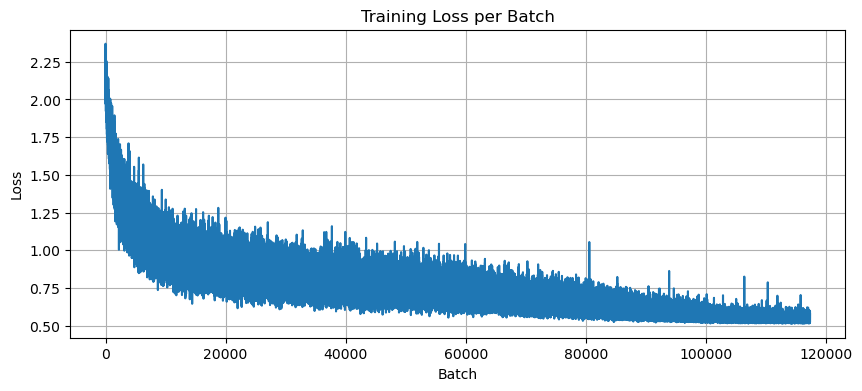

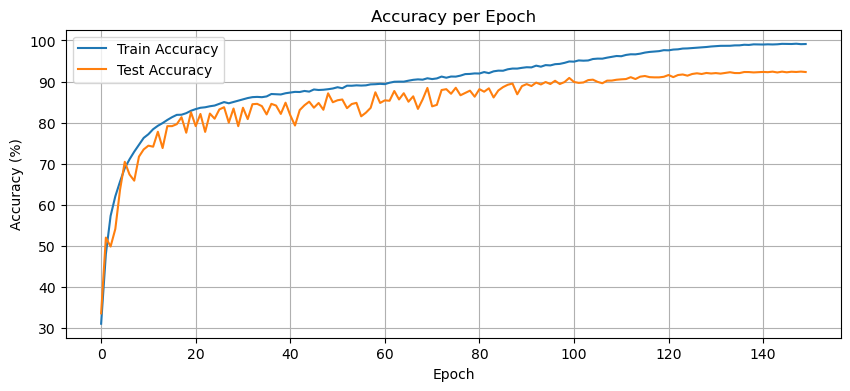

In [24]:
# Evaluation

# Plot loss per batch
plt.figure(figsize=(10, 4))
plt.plot(train_losses)
plt.title("Training Loss per Batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plot accuracy per epoch
plt.figure(figsize=(10, 4))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()
